In [360]:
#IMPORT KERAS
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [361]:
#Import other packages
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob, datetime

In [362]:
#Use os.listdir() method to list down all the image file, then use a for loop to read the images.
"""
for ____ in os.listdir(____):
    function you will use here:
    os.path.join()
    cv2.imread()
    cv2.cvtColor()
    cv2.resize()

Use this for loop, do the same thing for the label. But I suggest you read the label as a grayscale image.
"""
def load_images(filepath):
    images = []
    masks = []
    #2. Load images
    image_path = os.path.join(filepath,'inputs')
    for img in os.listdir(image_path):
        #Get the full path of the image file
        full_path = os.path.join(image_path,img)
        #Read the image file based on the full path
        img_np = cv2.imread(full_path)
        #Convert the image from bgr to rgb
        img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
        #Resize the image into 128x128
        img_np = cv2.resize(img_np,(128,128))
        #Place the image into the empty list
        images.append(img_np)

    #Load masks
    mask_path = os.path.join(filepath,'masks')
    for mask in os.listdir(mask_path):
        #Get the full path of the mask file
        full_path = os.path.join(mask_path,mask)
        #Read the mask file as a grayscale image
        mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
        #Resize the image into 128x128
        mask_np = cv2.resize(mask_np,(128,128))
        #Place the mask into the empty list
        masks.append(mask_np)

    #Convert the list of np array into a full np array
    images_np = np.array(images)
    masks_np = np.array(masks)

    #Data preprocessing
    #Expand the mask dimension to include the channel axis
    masks_np_exp = np.expand_dims(masks_np,axis=-1)
    #Convert the mask value into just 0 and 1
    converted_masks_np = np.round(masks_np_exp/255)
    #Normalize the images pixel value
    normalized_images_np = images_np/255.0

    return normalized_images_np , converted_masks_np

In [363]:
#Use the function to load train and test images separately
#Load train images
path_train = os.path.join("dataset","data-science-bowl-2018-2","train")
X_train, y_train = load_images(path_train)
#Load test images
path_test = os.path.join("dataset","data-science-bowl-2018-2","test")
X_test, y_test = load_images(path_test)

In [364]:
print(type(X_train))
print(X_train.shape)
print(type(X_test))
print(X_test.shape)

<class 'numpy.ndarray'>
(603, 128, 128, 3)
<class 'numpy.ndarray'>
(67, 128, 128, 3)


In [365]:
#Convert the numpy array into tensorflow tensors
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [366]:
#Combine features and labels together to form a zip dataset
train = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [367]:
#Custom class for augmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [368]:
print(train)

<_ZipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None))>


In [369]:
#Convert the zip dataset into prefetch dataset
TRAIN_LENGTH = 452
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
#Prepare dataset
train_batches = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

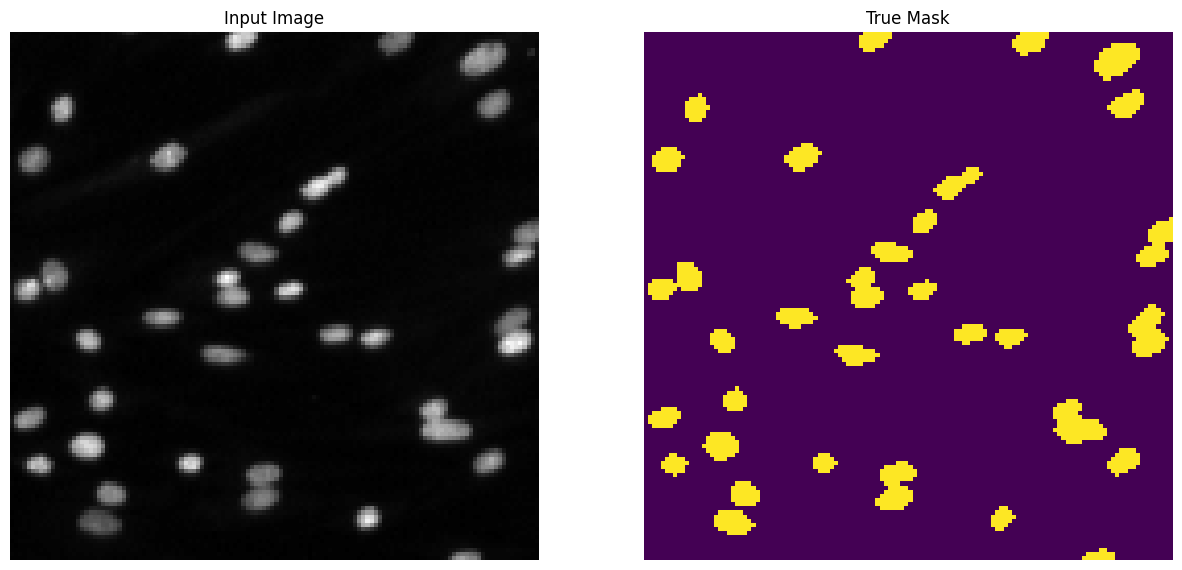

(64, 128, 128, 3)
(64, 128, 128, 1)


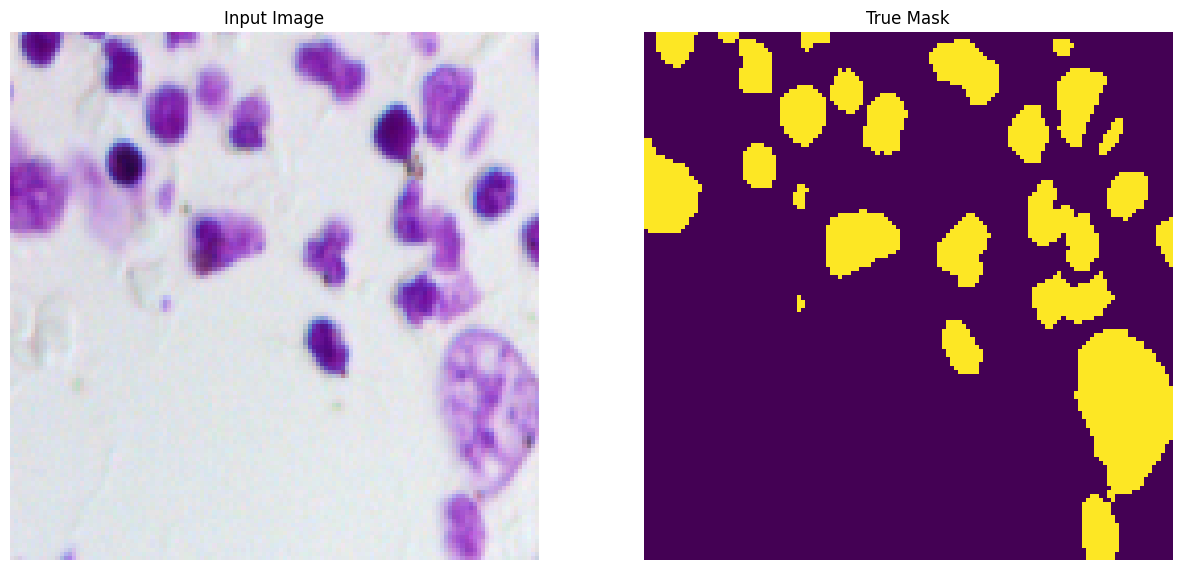

(64, 128, 128, 3)
(64, 128, 128, 1)


In [370]:
#function to vissualize image, label and prediction
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

#Test out the function to display an example
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])
  print(images.shape)
  print(masks.shape)

# About Unet

plan:
1. Use a pretrained model as feature extractor (in this example, we will use mobilenetv2)
2. Construct out own upsampling path according with the structure of the feature extractor.
3. This process can only be effectively done with functional API.
4. the model source can be refered here https://arxiv.org/abs/1505.04597

In [371]:
# MODEL development
# (A) Get the feature extractor using keras.applications
base_model = keras.applications.MobileNetV2(input_shape=sample_image.shape,include_top=False,alpha=0.5)
base_model.summary()

Model: "mobilenetv2_0.50_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_79      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        432 │ input_layer_79[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │        768 │ block_1_depthwis

 Total params: 706,224 (2.69 MB)

 Trainable params: 687,680 (2.62 MB)

 Non-trainable params: 18,544 (72.44 KB)

In [372]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False
down_stack.summary()

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_79      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        432 │ input_layer_79[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │        768 │ block_1_depthwis

 Total params: 495,664 (1.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 495,664 (1.89 MB)

In [373]:
#uppath

up_stack = [
    pix2pix.upsample(64, 3),  # 4x4 -> 8x8
    pix2pix.upsample(128, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(512, 3),   # 32x32 -> 64x64
]

In [374]:
#Create unet model
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [375]:
#use function to create unet
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.summary()

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_80      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_79       │ [(None, 64, 64,   │    495,664 │ input_layer_80[0… │
│ (Functional)        │ 48), (None, 32,   │            │                   │
│                     │ 32, 96), (None,   │            │                   │
│                     │ 16, 16, 96),      │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 288), (None, 4,   │            │                   │
│                     │ 4, 160)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 8, 8, 64)  │     92,416 │ functional_79[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 8, 8, 352) │          0 │ sequential_52[0]… │
│ (Concatenate)       │                   │            │ functional_79[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_53       │ (None, 16, 16,    │    406,016 │ concatenate_52[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_53      │ (None, 16, 16,    │          0 │ sequential_53[0]… │
│ (Concatenate)       │ 224)              │            │ functional_79[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_54       │ (None, 32, 32,    │    517,120 │ concatenate_53[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_54      │ (None, 32, 32,    │          0 │ sequential_54[0]… │
│ (Concatenate)       │ 352)              │            │ functional_79[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_55       │ (None, 64, 64,    │  1,624,064 │ concatenate_54[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_55      │ (None, 64, 64,    │          0 │ sequential_55[0]… │
│ (Concatenate)       │ 560)              │            │ functional_79[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_69 │ (None, 128, 128,  │     10,082 │ concatenate_55[0… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,145,362 (12.00 MB)

 Trainable params: 2,647,778 (10.10 MB)

 Non-trainable params: 497,584 (1.90 MB)

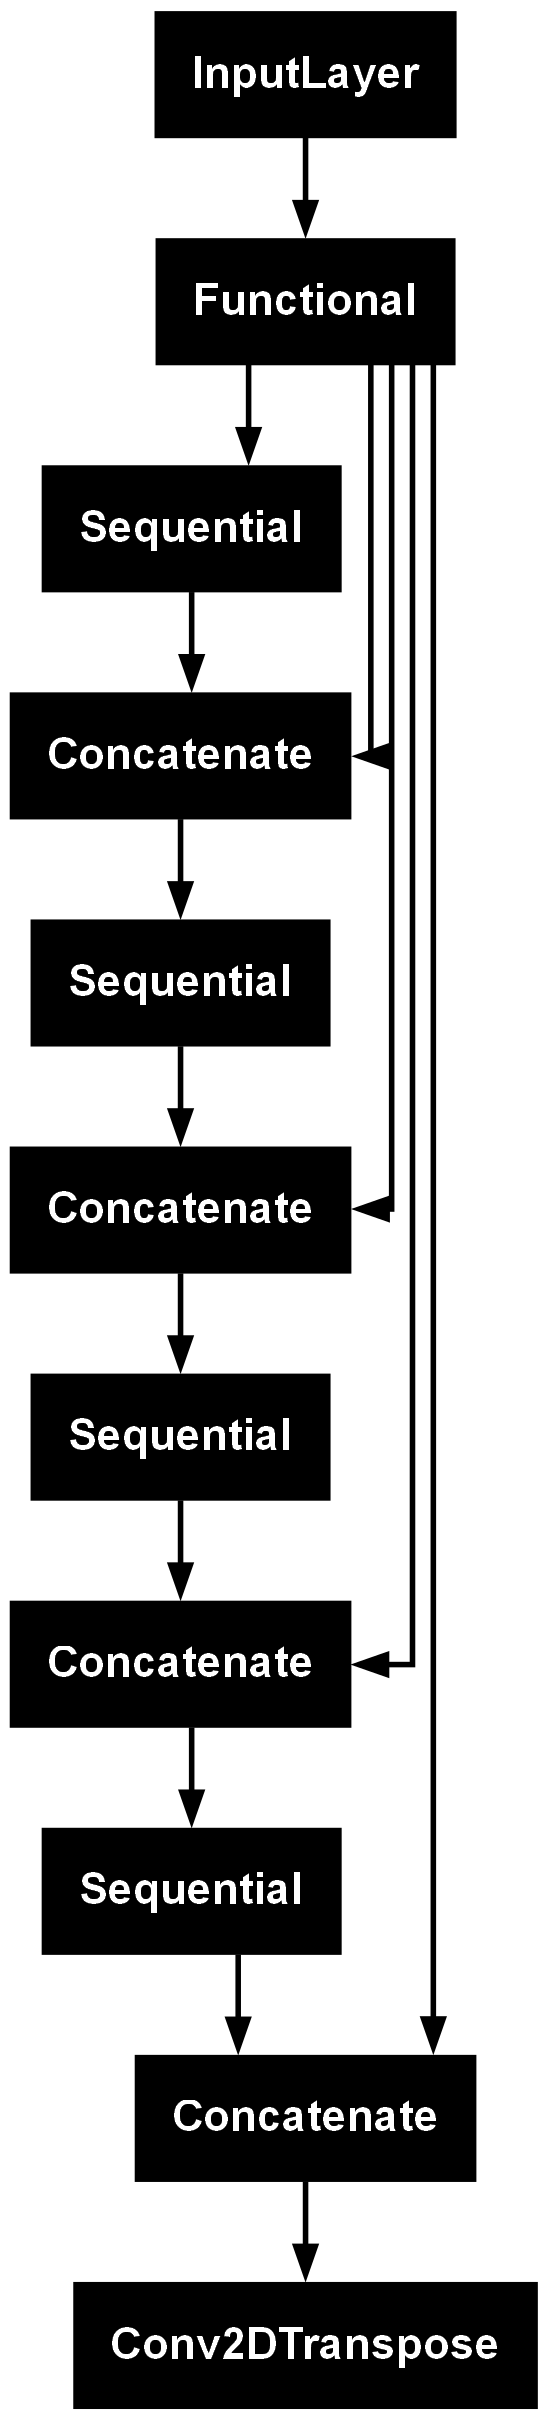

In [376]:
#plot model
keras.utils.plot_model(
    model,
    to_file="model.png")

In [377]:
#define loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) #doesn't need softmax activation when from logit is true
#define cosinedecay as scheduler to reduce momentum at late epoch 
schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate =0.0001,
    decay_steps = 100,
    warmup_target=0.01,
    warmup_steps=3)
optimizer = keras.optimizers.Adam(learning_rate=schedule)
#compile the model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [378]:
#Create Custom callback class
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


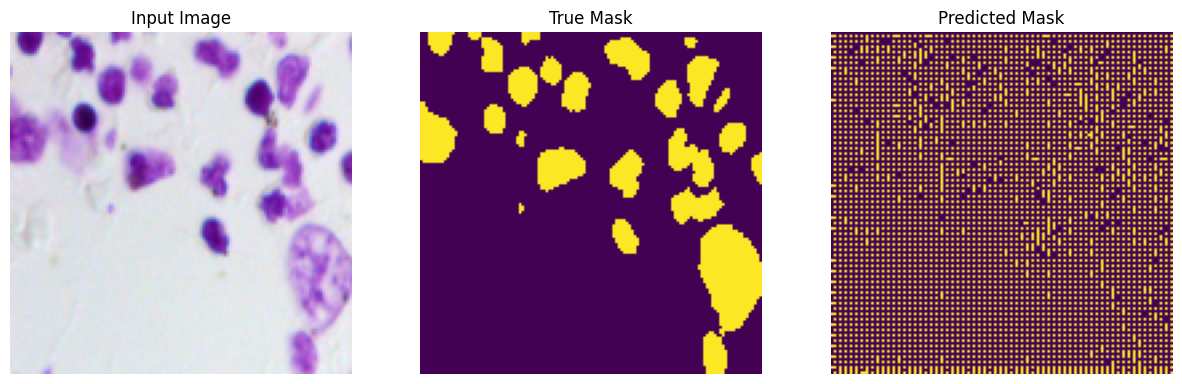

In [379]:
#test prediction without training
show_predictions()

In [380]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [381]:
#prepare for training
note = "finalized"
logpath = os.path.join("seg_log", datetime.datetime.now().strftime("%y%m%d-%H%M%S"),f"{note}")
tb = keras.callbacks.TensorBoard(logpath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


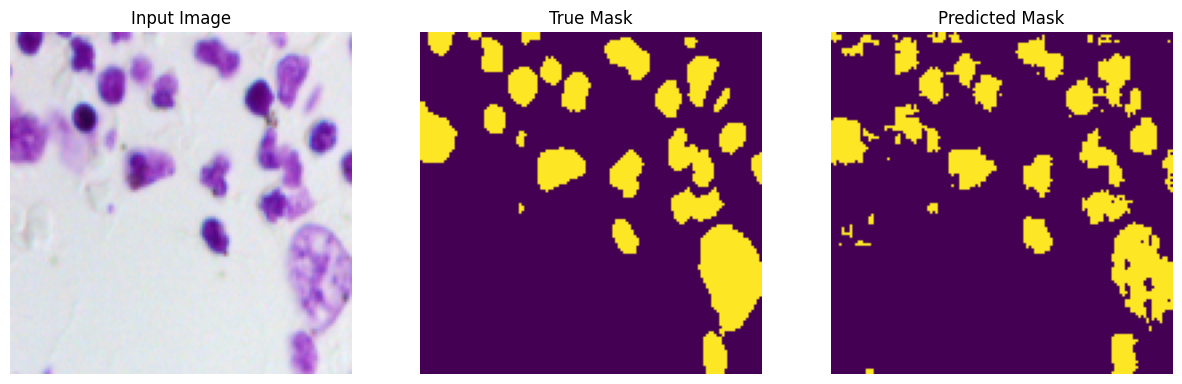


Sample Prediction after epoch 50

7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.9542 - loss: 0.1105 - val_accuracy: 0.9496 - val_loss: 0.1183


In [382]:
#Model training
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TRAIN_LENGTH//BATCH_SIZE//VAL_SUBSPLITS
stop = keras.callbacks.EarlyStopping(patience=3,verbose=1)
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[tb, DisplayCallback(),stop])

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step


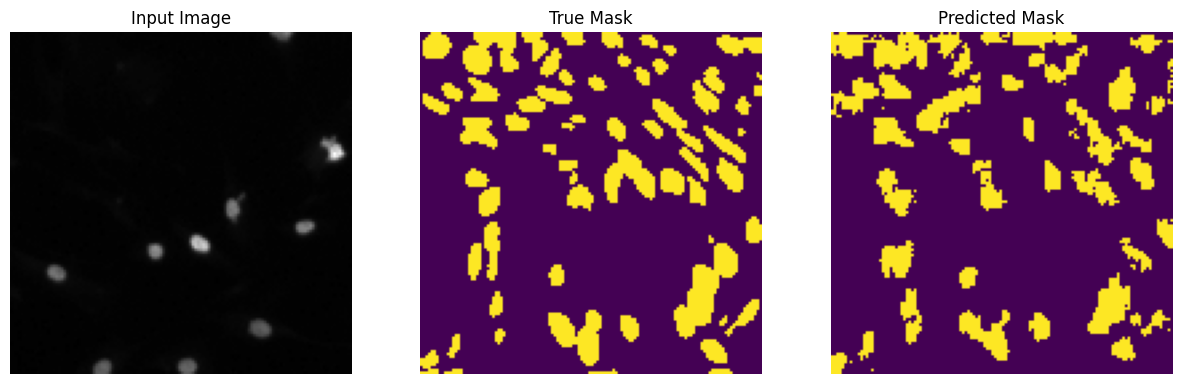

In [383]:
for test_img, test_label in test_batches.take(1):
    predictions = model.predict(test_img)
    predictions = np.argmax(predictions,axis = 3)
    predictions = np.expand_dims(predictions,axis=3)

#take data out to plot
display([test_img[7],test_label[17],predictions[17]])

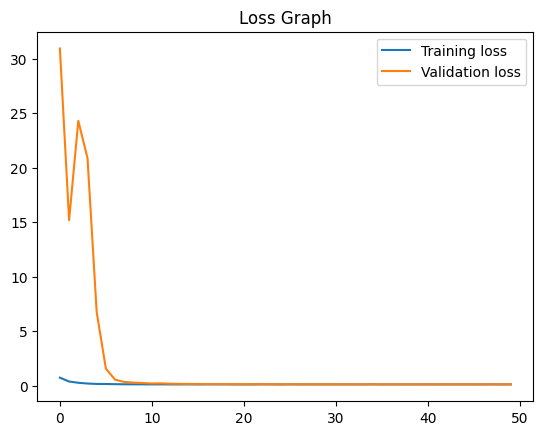

In [384]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss Graph')
plt.legend(['Training loss','Validation loss'])
plt.show()

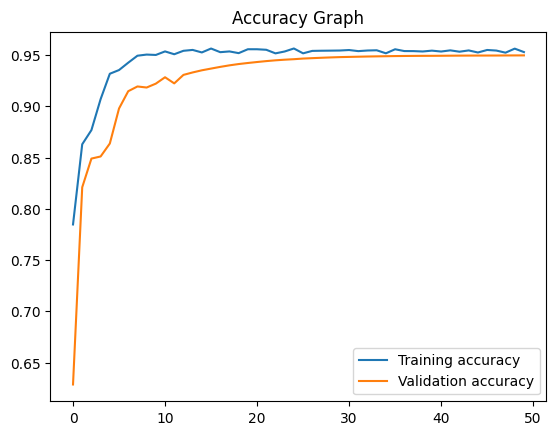

In [385]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Accuracy Graph')
plt.legend(['Training accuracy','Validation accuracy'])
plt.show()

In [386]:
#save keras model
model_filepath = os.path.join(os.getcwd(),'models','model.keras')
model.save(model_filepath, overwrite=True, zipped=None)

In [387]:
'''
#The function below can be use to load the model
def load_model(filepath):
    import keras  
    model = keras.saving.load_model(filepath, custom_objects=None, compile=True, safe_mode=True)
    return model
'''

'\n#The function below can be use to load the model\ndef load_model(filepath):\n    import keras  \n    model = keras.saving.load_model(filepath, custom_objects=None, compile=True, safe_mode=True)\n    return model\n'